Loaded rows: 801
Feature matrix shape after preprocessing: (801, 831)
PCA -> components: 20, shape: (801, 20)
Pairwise distance matrix computed.
Final DBSCAN run -> eps: 2.9684 min_samples: 10
Clusters (excluding noise): 16 Noise: 145 Silhouette: 0.5081184065686322


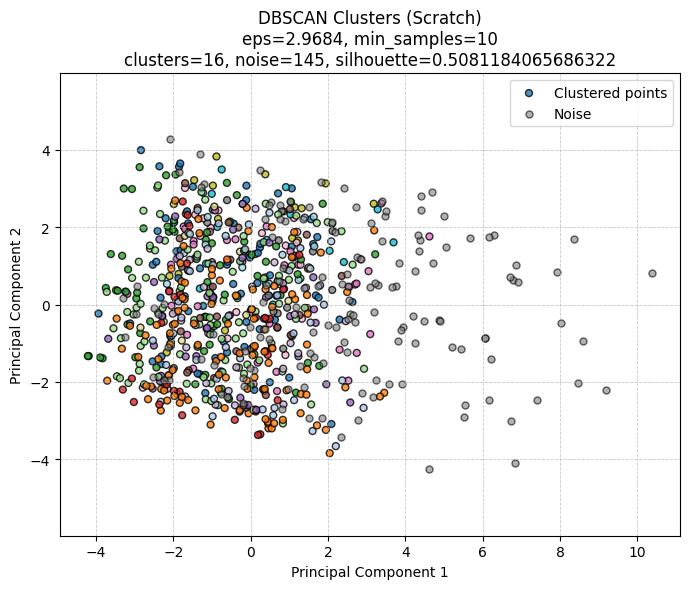

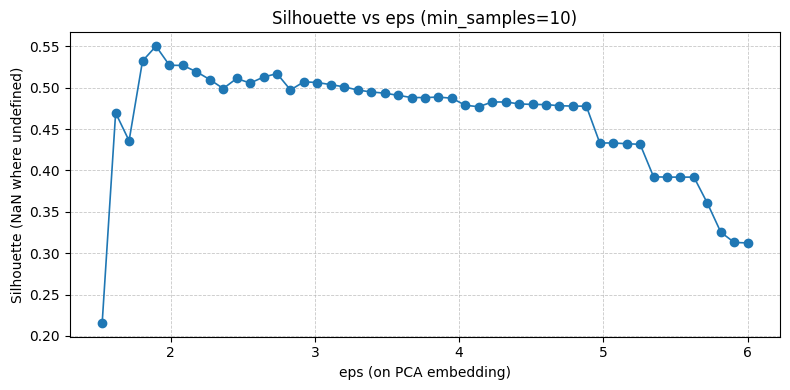

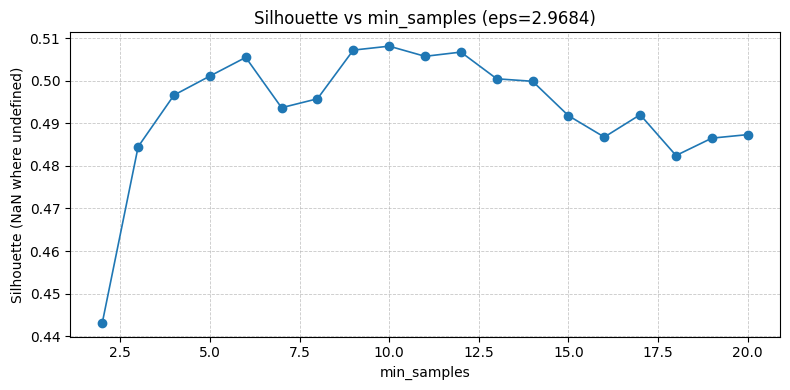

Saved labeled CSV to: pokedex_dbscan_pca20_eps2.968_min10_scratch.csv


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


INPUT_CSV = r"C:\Users\aparn\Downloads\pokedex.csv"

DEFAULT_EPS = 2.9684
DEFAULT_MIN_SAMPLES = 10

EPS_GRID = np.linspace(0.5, 6.0, 60)
MIN_SAMPLES_GRID = list(range(2, 21))

PCA_COMPONENTS = 20
OUTPUT_CSV = f"pokedex_dbscan_pca{PCA_COMPONENTS}_eps{DEFAULT_EPS:.3f}_min{DEFAULT_MIN_SAMPLES}_scratch.csv"

def median_impute(df_num):
    med = df_num.median(axis=0)
    return df_num.fillna(med)

def one_hot_encode(df_cat):
    if df_cat.shape[1] == 0:
        return pd.DataFrame(index=df_cat.index)
    return pd.get_dummies(df_cat.astype(str), dummy_na=False)

def standard_scale(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0, ddof=0)
    std_safe = np.where(std == 0, 1.0, std)
    Xs = (X - mean) / std_safe
    return Xs, mean, std_safe

def pca_svd(X, n_components):
    Xc = X - np.mean(X, axis=0)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    comps = Vt[:n_components]
    scores = Xc.dot(comps.T)
    return scores, comps

def pairwise_distances(X):
    sum_sq = np.sum(X**2, axis=1).reshape(-1,1)
    d2 = sum_sq + sum_sq.T - 2.0 * (X @ X.T)
    d2 = np.maximum(d2, 0.0)
    return np.sqrt(d2)

def dbscan_from_distances(D, eps, min_samples):
    n = D.shape[0]
    labels = np.full(n, -2, dtype=int)
    cluster_id = 0
    for i in range(n):
        if labels[i] != -2:
            continue
        neighbors = np.where(D[i] <= eps)[0]
        if neighbors.size < min_samples:
            labels[i] = -1
            continue
        labels[i] = cluster_id
        seed_queue = list(neighbors[neighbors != i])
        qi = 0
        while qi < len(seed_queue):
            j = seed_queue[qi]
            if labels[j] == -1:
                labels[j] = cluster_id
            if labels[j] != -2:
                qi += 1
                continue
            labels[j] = cluster_id
            j_neighbors = np.where(D[j] <= eps)[0]
            if j_neighbors.size >= min_samples:
                for nbr in j_neighbors:
                    if labels[nbr] == -2:
                        seed_queue.append(int(nbr))
            qi += 1
        cluster_id += 1
    return labels

def silhouette_from_distances(D, labels):
    mask = labels != -1
    idx = np.where(mask)[0]
    if idx.size == 0:
        return None
    labs = labels[mask]
    unique = np.unique(labs)
    if unique.size < 2:
        return None

    Dsub = D[np.ix_(idx, idx)]
    n = Dsub.shape[0]
    a = np.zeros(n)
    b = np.zeros(n)
    for i in range(n):
        li = labs[i]
        same = np.where(labs == li)[0]
        if same.size <= 1:
            a[i] = 0.0
        else:
            others = same[same != i]
            a[i] = np.mean(Dsub[i, others])
        other_labels = [l for l in unique if l != li]
        b_vals = []
        for ol in other_labels:
            ol_idx = np.where(labs == ol)[0]
            if ol_idx.size > 0:
                b_vals.append(np.mean(Dsub[i, ol_idx]))
        b[i] = min(b_vals) if len(b_vals) > 0 else 0.0
    denom = np.maximum(a, b)
    sil_sample = np.where(denom == 0, 0.0, (b - a) / denom)
    return float(np.mean(sil_sample))


def main():
    df = pd.read_csv(INPUT_CSV)
    print("Loaded rows:", df.shape[0])

 
    num_df = df.select_dtypes(include=[np.number]).copy()
    cat_df = df.select_dtypes(exclude=[np.number]).copy()

    num_imp = median_impute(num_df) if num_df.shape[1] > 0 else pd.DataFrame(index=df.index)
    cat_ohe = one_hot_encode(cat_df) if cat_df.shape[1] > 0 else pd.DataFrame(index=df.index)
    X_df = pd.concat([num_imp, cat_ohe], axis=1)
    print("Feature matrix shape after preprocessing:", X_df.shape)

  
    X = X_df.values.astype(float)
    Xs, _, _ = standard_scale(X)
    n_comp = min(PCA_COMPONENTS, Xs.shape[1])
    X_pca, _ = pca_svd(Xs, n_comp)
    print(f"PCA -> components: {n_comp}, shape: {X_pca.shape}")

   
    D = pairwise_distances(X_pca)
    print("Pairwise distance matrix computed.")


    sil_vs_eps = []
    for eps in EPS_GRID:
        labels = dbscan_from_distances(D, eps=eps, min_samples=DEFAULT_MIN_SAMPLES)
        sil = silhouette_from_distances(D, labels)
        sil_vs_eps.append(np.nan if sil is None else sil)

   
    sil_vs_ms = []
    for ms in MIN_SAMPLES_GRID:
        labels = dbscan_from_distances(D, eps=DEFAULT_EPS, min_samples=ms)
        sil = silhouette_from_distances(D, labels)
        sil_vs_ms.append(np.nan if sil is None else sil)

  
    final_labels = dbscan_from_distances(D, eps=DEFAULT_EPS, min_samples=DEFAULT_MIN_SAMPLES)
    n_clusters = len([l for l in set(final_labels) if l != -1])
    n_noise = int(np.sum(final_labels == -1))
    final_sil = silhouette_from_distances(D, final_labels)

    print("Final DBSCAN run -> eps:", DEFAULT_EPS, "min_samples:", DEFAULT_MIN_SAMPLES)
    print("Clusters (excluding noise):", n_clusters, "Noise:", n_noise, "Silhouette:", final_sil)

   
    plt.figure(figsize=(7,6))
    plt.title(
        f"DBSCAN Clusters (Scratch)\n"
        f"eps={DEFAULT_EPS}, min_samples={DEFAULT_MIN_SAMPLES}\n"
        f"clusters={n_clusters}, noise={n_noise}, silhouette={final_sil if final_sil is not None else 'NA'}"
    )

 
    clustered_mask = final_labels != -1
    plt.scatter(
        X_pca[clustered_mask, 0], X_pca[clustered_mask, 1],
        c=final_labels[clustered_mask],
        s=25, cmap='tab20', edgecolor='k', alpha=0.8, label='Clustered points'
    )

 
    noise_mask = final_labels == -1
    if np.sum(noise_mask) > 0:
        plt.scatter(
            X_pca[noise_mask, 0], X_pca[noise_mask, 1],
            c='gray', s=25, edgecolor='k', alpha=0.6, label='Noise'
        )

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.axis('equal')
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    
    plt.figure(figsize=(8,4))
    plt.plot(EPS_GRID, sil_vs_eps, marker='o', linewidth=1.2)
    plt.xlabel("eps (on PCA embedding)")
    plt.ylabel("Silhouette (NaN where undefined)")
    plt.title(f"Silhouette vs eps (min_samples={DEFAULT_MIN_SAMPLES})")
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(8,4))
    plt.plot(MIN_SAMPLES_GRID, sil_vs_ms, marker='o', linewidth=1.2)
    plt.xlabel("min_samples")
    plt.ylabel("Silhouette (NaN where undefined)")
    plt.title(f"Silhouette vs min_samples (eps={DEFAULT_EPS})")
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    plt.tight_layout()
    plt.show()

    
    out_df = df.copy()
    out_df[f"dbscan_label_pca{n_comp}_eps{DEFAULT_EPS:.3f}_min{DEFAULT_MIN_SAMPLES}_scratch"] = final_labels
    out_df.to_csv(OUTPUT_CSV, index=False)
    print("Saved labeled CSV to:", OUTPUT_CSV)

if __name__ == "__main__":
    main()
